In [1]:
# add ../src directory to path
import sys
sys.path.append('../src')

from utils import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Grid search for each lightcurve
Iterate over every possible anomalous interval (from nyquist frequency to 10% of lightcurve) in lightcurve, and train GP on data without this interval.
Choose  most likely interval using the lowest metric.

In [2]:
lightcurve_number = 1
data_dir = "../results/"
data_name = f"grid_search/gp_initial_{lightcurve_number}.txt" 

# results are stored in a txt file, with header: start,end,metric
data = pd.read_csv(data_dir + data_name, header=0, sep=",")
print(data.head())

# find the best metric start and end interval
best_metric = data["metric"].max()
best_interval = data[data["metric"] == best_metric]
start = int(best_interval["start"].values[0])
end = int(best_interval["end"].values[0])
print(best_interval)

   start  end    metric
0      0   23 -0.825480
1      0   24 -0.828047
2      0   25 -0.825780
3      0   26 -0.818882
4      0   27 -0.828137
         start   end    metric
1008942   2697  2984 -0.814069


/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/scripts/../src/utils.py:203: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))


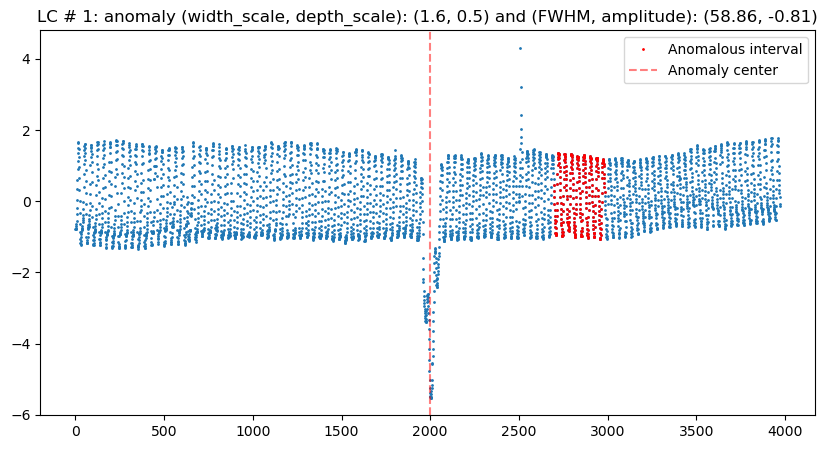

In [13]:
# Load the lightcurve
shape = "gaussian"
width_scale = 1.6
depth_scale = 0.5
loc = 2000

# Load the data
data_dir = '../data/k2/'
filename = f'k2_{lightcurve_number}.fits'
x, y, y_err = load_k2_data(data_dir + filename)

# Scale data to be between 0 and 1
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y_err = y_err / (np.max(y) - np.min(y))

# Inject anomalies
steps, y, anomaly_locs, anomaly_amp, anomaly_fwhm = inject_anomaly(
    y, 
    num_anomalies=1, 
    seed=lightcurve_number, 
    shapes=[shape],
    width_scale=width_scale,
    depth_scale=depth_scale,
    anomaly_idx=[loc]
)

# Standardize data to have mean 0 and std of 1
mean_y = np.mean(y)
std_y = np.std(y)
y = (y - mean_y) / std_y
y_err = y_err / std_y

# Plot the lightcurve, injected anomaly center, and the anomalous interval
plt.figure(figsize=(10,5))
plt.plot(range(len(x)), y, '.', markersize=2)
plt.plot(range(start, end), y[start:end], '.', color='r', markersize=2, label='Anomalous interval')
for i in range(len(anomaly_locs)):
    plt.axvline(x=anomaly_locs[i], color='r', linestyle='--', alpha=0.5, label='Anomaly center')
plt.legend()
plt.title(f"LC # {lightcurve_number}: anomaly (width_scale, depth_scale): ({width_scale}, {depth_scale}) and (FWHM, amplitude): ({anomaly_fwhm:.2f}, {anomaly_amp:.2f})")
plt.show()

## Varying size for random files and locs
Random injection sites and files with varying anoamly sizes. Create 1x1 plot summarizing 100 repeats for each grid

In [11]:
data_dir = "../results/"
data_name = "gp_vary_size_100_reframed" 
# note gp_vary_size_100_repeats_fixed is missing some values for width 24, so remove those

results = pd.read_csv(data_dir + data_name + ".csv")
print(len(results))

# Count for each amp and width_stdev the total number of filenames and locations that were marked as identified = 1.0
grouped = results.groupby(["depth_scale", "width_scale"]).agg(
    num_identified=('identified', 'sum'),
    total_experiments=('identified', 'count')
).reset_index()

grouped["identified_ratio"] = grouped["num_identified"] / grouped["total_experiments"]

print(len(grouped))
grouped.head()

10862
105


,depth_scale,width_scale,num_identified,total_experiments,identified_ratio
0,0.5,0.1,92.0,100,0.92
1,0.5,0.2,82.0,100,0.82
2,0.5,0.3,72.0,100,0.72
3,0.5,0.4,73.0,100,0.73
4,0.5,0.5,69.0,100,0.69


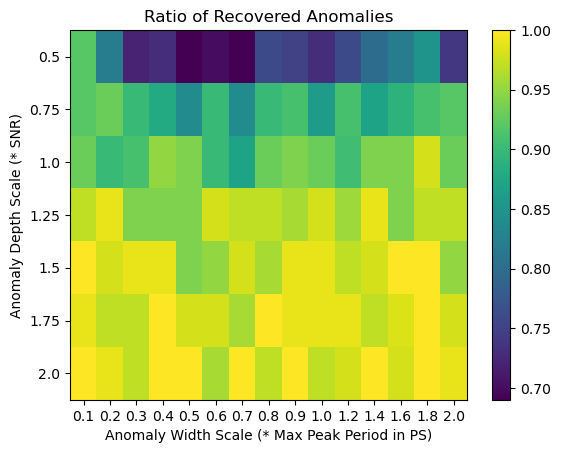

In [12]:
# Plot an imshow image colored by identified_ratio, x_axis is width_stdev, y_axis is amp
pivot = grouped.pivot(index='depth_scale', columns='width_scale', values='identified_ratio')
plt.imshow(pivot, cmap='viridis', interpolation='nearest', aspect='auto')
cbar = plt.colorbar()
plt.xlabel("Anomaly Width Scale (* Max Peak Period in PS)")
plt.ylabel("Anomaly Depth Scale (* SNR)")
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.title("Ratio of Recovered Anomalies")
plt.savefig(data_dir + data_name + ".png")
plt.show()

## Varying size and amplitude for single files but random locs analysis
Create a 3x1 plot with above plot for each of the 3 lightcurves

In [15]:
data_dir = "../results/"
data_name = "gp_vary_size_100_repeats_3files_reframed" 

results = pd.read_csv(data_dir + data_name + ".csv")
print(len(results))

# Get unique filenames and locations
filenames = results['filename'].unique()
short_filenames = [filename.split('k2_')[1].split('.fits')[0] for filename in filenames]
print(filenames, short_filenames)

# Count for each amp and width_stdev the total number of filenames and locations that were marked as identified = 1.0
grouped = results.groupby(["depth_scale", "width_scale", "filename"]).agg(
    num_identified=('identified', 'sum'),
    total_experiments=('identified', 'count')
).reset_index()

grouped["identified_ratio"] = grouped["num_identified"] / grouped["total_experiments"]

print(len(grouped))
grouped.head()

27381
['k2_3.fits' 'k2_18.fits' 'k2_48.fits'] ['3', '18', '48']
252


,depth_scale,width_scale,filename,num_identified,total_experiments,identified_ratio
0,0.5,0.1,k2_18.fits,39.0,100,0.390000
1,0.5,0.1,k2_3.fits,100.0,100,1.000000
2,0.5,0.1,k2_48.fits,56.0,100,0.560000
3,0.5,0.2,k2_18.fits,73.0,100,0.730000
4,0.5,0.2,k2_3.fits,148.0,156,0.948718


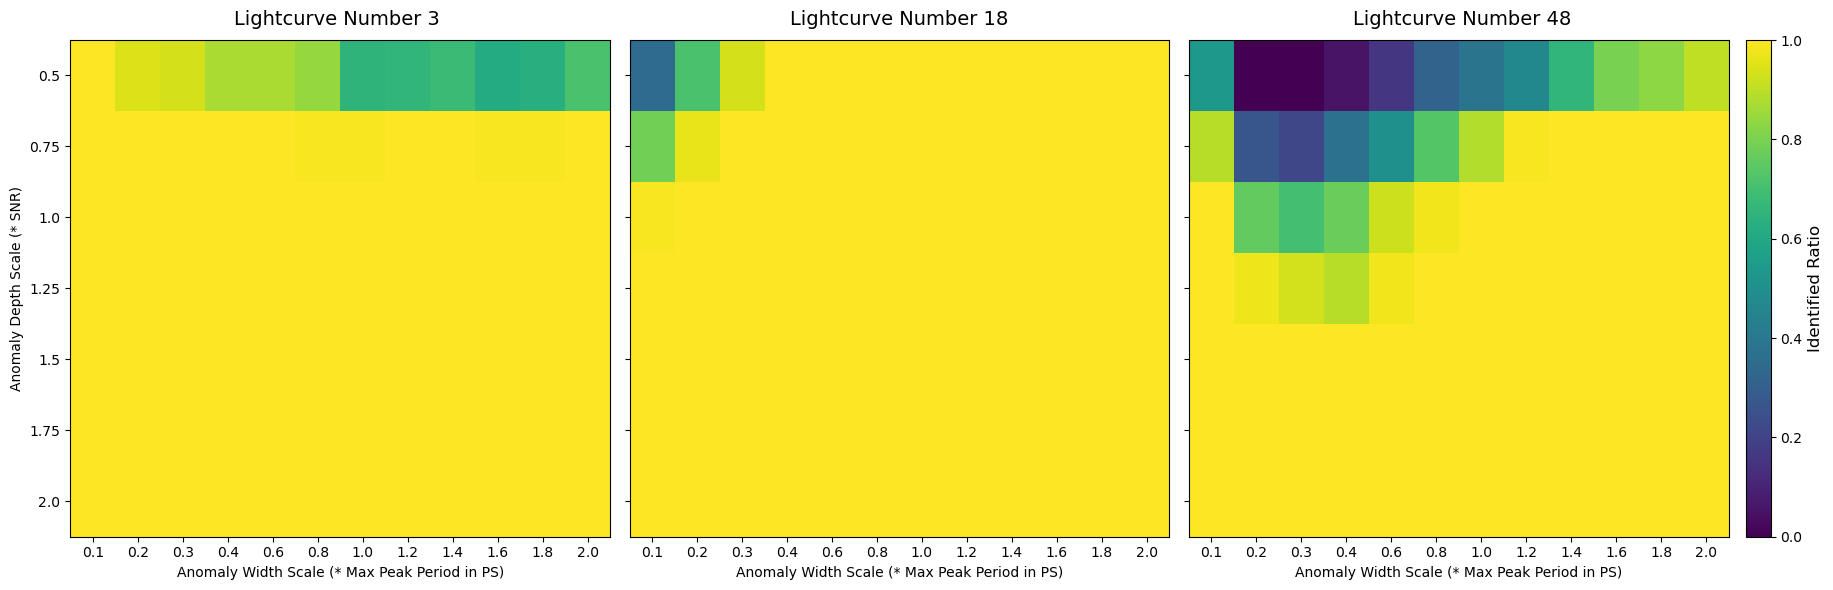

In [16]:
# Create figure
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# fig.suptitle("Ratio of Recovered Anomalies", fontsize=16)
for ax in axs.flat:
    ax.label_outer()

# Colorbar placeholder
im = None

# Colorbar min and max
vmin = grouped['identified_ratio'].min()
vmax = grouped['identified_ratio'].max()

# Plot each filename and location
for i, filename in enumerate(filenames):
    # Filter to only the current filename and label with filename
    filename_grouped = grouped[grouped['filename'] == filename]
    fig.text(0.19 + i / 3.2, 0.95, f"Lightcurve Number {short_filenames[i]}", ha='center', fontsize=14)

    # Plot an imshow image colored by identified_ratio, x_axis is width_stdev, y_axis is amp
    pivot = filename_grouped.pivot(index='depth_scale', columns='width_scale', values='identified_ratio')
    axs[i].imshow(pivot, cmap='viridis', interpolation='nearest', aspect='auto', vmin=vmin, vmax=vmax)
    if i==0: axs[i].set_ylabel("Anomaly Depth Scale (* SNR)")
    axs[i].set_xlabel("Anomaly Width Scale (* Max Peak Period in PS)")
    axs[i].set_xticks(range(len(pivot.columns)), pivot.columns)
    axs[i].set_yticks(range(len(pivot.index)), pivot.index)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add a single colorbar to the right of the subplots
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Identified Ratio', fontsize=12)

# Save and show the figure
plt.savefig(data_dir + data_name + ".png")
plt.show()

## Varying size for single locs and files analysis
Particular injections sites and filenames, create 3x3 plot

In [44]:
data_dir = "../results/"
data_file = "gp_varying_anomaly_size_results.csv"

# Load data
results = pd.read_csv(data_dir + data_file)
results = results[results['location_idx'] != 2000]
results = results[results['location_idx'] != 3500]

# Get unique filenames and locations
filenames = results['filename'].unique()
short_filenames = [filename.split('k2_')[1].split('.fits')[0] for filename in filenames]
locations = results['location_idx'].unique()

# Print
print(filenames, short_filenames)
print(locations)
results.head()

['k2_3.fits' 'k2_18.fits' 'k2_48.fits'] ['3', '18', '48']
[ 500 1750 3000]


,filename,amp,width_stdev,shape,location_idx,flagged_anomalies,identified,identified_ratio
0,k2_3.fits,-4.0,14,gaussian,500,[ 455 456 457 458 459 460 461 462 463 ...,1.0,1.0
1,k2_3.fits,-5.0,2,gaussian,500,[ 480 481 482 483 484 485 486 487 488 ...,1.0,1.0
2,k2_3.fits,-4.0,2,gaussian,500,[ 490 491 492 493 494 495 496 497 498 ...,1.0,1.0
3,k2_3.fits,-3.0,2,gaussian,500,[ 492 493 494 495 496 497 498 499 500 ...,1.0,1.0
4,k2_3.fits,-2.0,2,gaussian,500,[ 492 493 494 495 496 497 498 499 500 ...,1.0,1.0


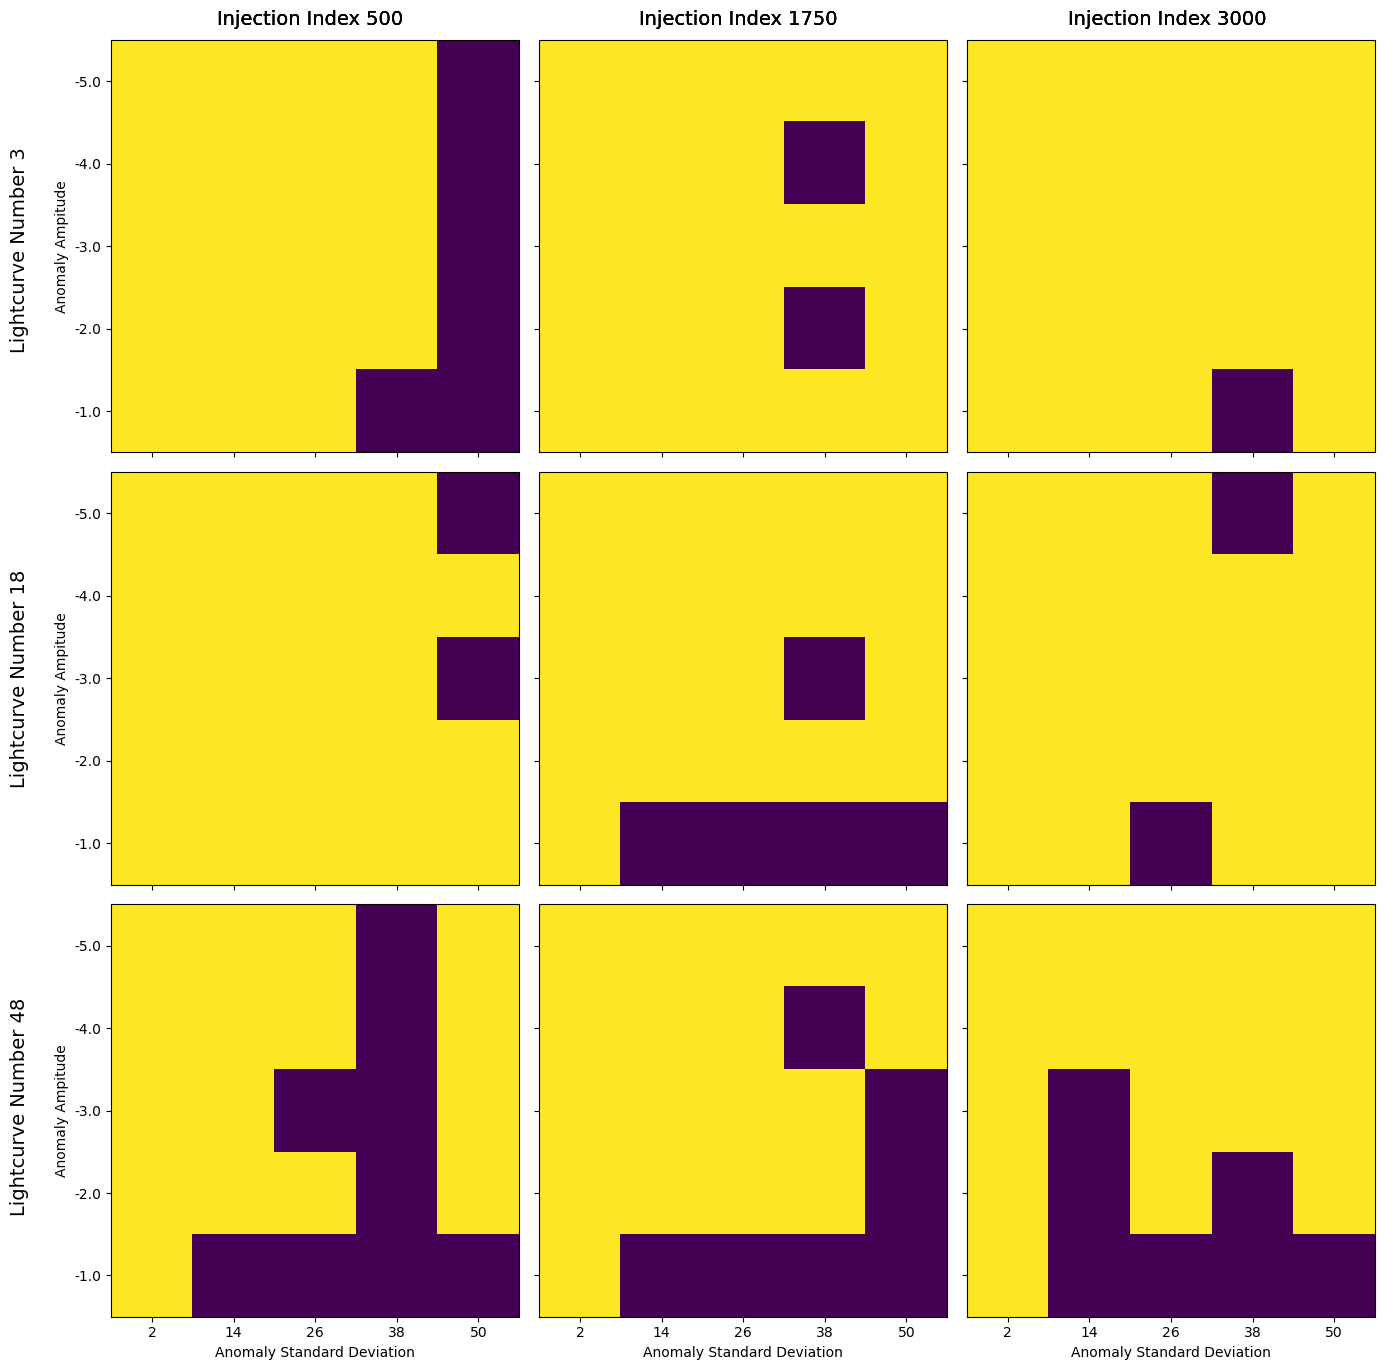

In [45]:
# Create figure
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
# fig.suptitle('Yellow: Anomaly Recovered, Purple: Anomaly Not Recovered', fontsize=16)
for ax in axs.flat:
    ax.label_outer()

# Plot each filename and location
for i, filename in enumerate(filenames):
    # Label the row and y axis of outer plot
    axs[i, 0].set_ylabel(f"Anomaly Ampitude")
    fig.text(0.03, 0.8 - i / 3.5, f"Lightcurve Number {short_filenames[i]}", va='center', rotation='vertical', fontsize=14)

    for j, location in enumerate(locations):
        # Label the column and x axis of outer plot
        axs[2, j].set_xlabel(f"Anomaly Standard Deviation")
        fig.text(0.23 + j / 3.5, 0.95, f"Injection Index {location}", ha='center', fontsize=14)

        current = results[results['filename'] == filename]
        current = current[current['location_idx'] == location]
        current = current.drop_duplicates(subset=['amp', 'width_stdev'])

        pivot = current.pivot(index='amp', columns='width_stdev', values='identified_ratio')
        axs[i, j].imshow(pivot, cmap='viridis', interpolation='nearest', aspect='auto')
        axs[i, j].set_xticks(range(len(pivot.columns)))
        axs[i, j].set_xticklabels(pivot.columns)
        axs[i, j].set_yticks(range(len(pivot.index)))
        axs[i, j].set_yticklabels(pivot.index)

plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.savefig(data_dir + data_name + ".png")
plt.show()